In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import seaborn as sns
from scipy.stats import chi2_contingency
from google.colab import drive
from keras import regularizers
from keras.layers import Dropout

In [ ]:
from tensorflow.keras.utils import to_categorical # Use to_categorical directly from tensorflow.keras.utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
events = pd.read_csv('/content/drive/My Drive/events_vf.csv')

In [ ]:
events.head()

,timestamp,visitorid,event,itemid,transactionid,is_transaction,datetime,month,day_of_week,hour,hour_sin,hour_cos
0,1433221332117,257597,2,355908,0.0,0,2015-06-02 05:02:12.117,6,1,5,0.965926,0.258819
1,1433224214164,992329,2,248676,0.0,0,2015-06-02 05:50:14.164,6,1,5,0.965926,0.258819
2,1433221999827,111016,2,318965,0.0,0,2015-06-02 05:13:19.827,6,1,5,0.965926,0.258819
3,1433221955914,483717,2,253185,0.0,0,2015-06-02 05:12:35.914,6,1,5,0.965926,0.258819
4,1433221337106,951259,2,367447,0.0,0,2015-06-02 05:02:17.106,6,1,5,0.965926,0.258819


In [ ]:
events=events[['timestamp','visitorid','itemid','event','day_of_week','hour_sin','hour_cos','is_transaction']]

In [ ]:
events

,timestamp,visitorid,itemid,event,day_of_week,hour_sin,hour_cos,is_transaction
0,1433221332117,257597,355908,2,1,0.965926,0.258819,0
1,1433224214164,992329,248676,2,1,0.965926,0.258819,0
2,1433221999827,111016,318965,2,1,0.965926,0.258819,0
3,1433221955914,483717,253185,2,1,0.965926,0.258819,0
4,1433221337106,951259,367447,2,1,0.965926,0.258819,0
...,...,...,...,...,...,...,...,...
2756096,1438398785939,591435,261427,2,0,0.707107,0.707107,0
2756097,1438399813142,762376,115946,2,0,0.707107,0.707107,0
2756098,1438397820527,1251746,78144,2,0,0.500000,0.866025,0
2756099,1438398530703,1184451,283392,2,0,0.707107,0.707107,0


In [ ]:
# Création de 4 exemples négatifs pour chaque exemple positif
num_negatives = 25
# Dataset de transactions positives
positive_samples = events[events['is_transaction'] == 1]
# Dataset de non-transactions pour créer les exemples négatifs
negative_samples = events[events['is_transaction'] == 0]
# Liste des itemid des exemples positifs (items achetés)
positive_item_ids = positive_samples['itemid'].unique()

# on supprime les articles dans les exemples négatifs qui sont déjà dans les exemples positifs.
negative_samples_filtered = negative_samples[~negative_samples['itemid'].isin(positive_item_ids)]

# on génère des exemples négatifs en échantillonnant les articles non achetés.
#On en prend 4 fois plus que le nombre d'exemples positifs pour équilibrer les données
negative_samples = negative_samples_filtered.sample(n=len(positive_samples) * num_negatives, replace=True, random_state=42)

# on combine les échantillons positifs et négatifs
balanced_df = pd.concat([positive_samples, negative_samples])

# on melange le dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
balanced_df

,timestamp,visitorid,itemid,event,day_of_week,hour_sin,hour_cos,is_transaction
0,1434402381717,708229,331069,2,1,-0.707107,0.707107,0
1,1434833236998,919028,245400,1,0,-0.866025,0.500000,1
2,1438222030102,484405,111418,2,1,0.500000,0.866025,0
3,1441677620390,45470,210359,2,1,0.500000,0.866025,0
4,1430712279378,227466,183028,2,1,0.866025,0.500000,0
...,...,...,...,...,...,...,...,...
583851,1433828867010,245098,172905,2,1,0.965926,0.258819,0
583852,1438796421629,1288944,374275,2,1,-0.965926,-0.258819,0
583853,1435859996617,869934,882,2,1,-0.965926,-0.258819,0
583854,1436499748742,1183638,395345,2,1,0.707107,0.707107,0


In [ ]:
data1 = pd.read_csv('/content/drive/My Drive/item_properties_part1.csv')
data2 = pd.read_csv('/content/drive/My Drive/item_properties_part2.csv')
item_properties=pd.concat([data1,data2])
item_properties = item_properties[item_properties['property'] == 'categoryid']
item_properties = item_properties.sort_values(by=['itemid', 'timestamp'])
item_properties = item_properties.drop_duplicates(subset='itemid', keep='last')
item_properties = item_properties[['itemid', 'value']].rename(columns={'value': 'categoryid'})


In [ ]:
balanced_df = pd.merge(balanced_df, item_properties, on='itemid', how='left')
balanced_df = balanced_df.sort_values('timestamp').drop_duplicates(['visitorid', 'itemid'], keep='last')

In [ ]:
balanced_df

,timestamp,visitorid,itemid,event,day_of_week,hour_sin,hour_cos,is_transaction,categoryid
152439,1430622011289,829044,60987,2,0,0.707107,0.707107,0,463
174952,1430622013048,652699,252860,2,0,0.707107,0.707107,0,NaN
408001,1430622029427,693516,297662,0,0,0.707107,0.707107,0,1130
376444,1430622040988,1399056,197200,2,0,0.707107,0.707107,0,683
292358,1430622045993,181106,278445,2,0,0.707107,0.707107,0,1339
...,...,...,...,...,...,...,...,...,...
100754,1442545151261,1249751,404734,2,1,0.500000,0.866025,0,1233
92871,1442545153842,998517,354400,2,1,0.500000,0.866025,0,956
332614,1442545164029,472345,301436,2,1,0.500000,0.866025,0,1244
340036,1442545165499,1207677,310922,2,1,0.500000,0.866025,0,565


In [ ]:
balanced_df['categoryid'].isna().sum()

60183

In [ ]:
balanced_df['categoryid'].fillna(-1, inplace=True)

<ipython-input-157-04448d80daf6>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  balanced_df['categoryid'].fillna(-1, inplace=True)


In [ ]:
balanced_df['categoryid'].isna().sum()

0

In [ ]:
events=balanced_df[['visitorid', 'itemid','event','day_of_week','hour_sin','hour_cos','categoryid','is_transaction']]

In [ ]:
y_one_hot = to_categorical(events['is_transaction'])

In [ ]:
y_one_hot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
X=events[['visitorid', 'itemid','event','day_of_week','hour_sin','hour_cos','categoryid']]

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
# Définir les tailles de vocabulaire et les dimensions d'embedding
visitor_vocab_size = len(X['visitorid'].unique())
item_vocab_size = len(X['itemid'].unique())
category_vocab_size = len(X['categoryid'].unique())
embedding_dim = 10  # La dimension d'embedding
num_classes = y_one_hot.shape[1]  # Le nombre de classes (multi-classes)

def create_model(visitor_vocab_size, item_vocab_size, category_vocab_size, embedding_dim, num_classes):
    # Embedding pour visitorid
    visitor_input = Input(shape=(1,), name='visitor_input')
    visitor_embedding = Embedding(input_dim=visitor_vocab_size, output_dim=embedding_dim)(visitor_input)
    visitor_embedding = Flatten()(visitor_embedding)

    # Embedding pour itemid
    item_input = Input(shape=(1,), name='item_input')
    item_embedding = Embedding(input_dim=item_vocab_size, output_dim=embedding_dim)(item_input)
    item_embedding = Flatten()(item_embedding)

    # Embedding pour categoryid
    category_input = Input(shape=(1,), name='category_input')
    category_embedding = Embedding(input_dim=category_vocab_size, output_dim=embedding_dim)(category_input)
    category_embedding = Flatten()(category_embedding)

    # Ajout des autres features
    additional_features_input = Input(shape=(3,), name='additional_features')

    # Concatenation des embeddings et des autres features
    concatenated = Concatenate()([visitor_embedding, item_embedding, category_embedding, additional_features_input])

    # Ajout de couches denses
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(concatenated)
    x = Dropout(0.7)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.7)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Créer le modèle
    model = Model(inputs=[visitor_input, item_input, category_input, additional_features_input], outputs=output)

    # Compiler le modèle
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
visitor_vocab_size,item_vocab_size,category_vocab_size

(389270, 143755, 1051)

In [ ]:
# Initialiser le KFold avec 5 divisions (par exemple)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
#Boucle sur chaque pli du KFold
for train_idx, val_idx in kfold.split(X):
    # Diviser les données en jeu d'entraînement et de validation
    X_train_visitorid, X_val_visitorid = X['visitorid'].values[train_idx], X['visitorid'].values[val_idx]
    X_train_itemid, X_val_itemid = X['itemid'].values[train_idx], X['itemid'].values[val_idx]
    X_train_categoryid, X_val_categoryid = X['categoryid'].values[train_idx], X['categoryid'].values[val_idx]
    X_train_additional, X_val_additional = X[['day_of_week', 'hour_sin', 'hour_cos']].values[train_idx], X[['day_of_week', 'hour_sin', 'hour_cos']].values[val_idx]

    # Assure-toi que toutes les colonnes catégorielles sont de type int64
    X_train_visitorid = X_train_visitorid.astype('int64')
    X_train_itemid = X_train_itemid.astype('int64')
    X_train_categoryid = X_train_categoryid.astype('int64')

# Assure-toi que les autres features sont de type float32
    X_train_additional = X_train_additional.astype('float32')

# Répéter cela pour X_val aussi
    X_val_visitorid = X_val_visitorid.astype('int64')
    X_val_itemid = X_val_itemid.astype('int64')
    X_val_categoryid = X_val_categoryid.astype('int64')
    X_val_additional = X_val_additional.astype('float32')
    # Extraire les labels correspondants
    y_train, y_val = y_one_hot[train_idx], y_one_hot[val_idx]

    # Créer et entraîner le modèle pour ce pli
    model = create_model(visitor_vocab_size, item_vocab_size, category_vocab_size, embedding_dim, num_classes)
       # Entraîner le modèle
    history=model.fit(
        [X_train_visitorid, X_train_itemid, X_train_categoryid, X_train_additional],
        y_train,
        epochs=10,
        batch_size=32,
        validation_data=([X_val_visitorid, X_val_itemid, X_val_categoryid, X_val_additional], y_val),
        verbose=1,
        callbacks=[early_stopping],
        shuffle=True
    )
     # Stocker les pertes et précisions pour chaque pli
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])

    # Évaluer le modèle sur l'ensemble de validation
    scores = model.evaluate([X_val_visitorid, X_val_itemid, X_val_categoryid, X_val_additional], y_val, verbose=0)
    results.append(scores[1])  # Stocker la précision



Epoch 1/10
11795/11795 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.9522 - loss: 0.2181 - val_accuracy: 0.9539 - val_loss: 0.1750
Epoch 2/10
11795/11795 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9553 - loss: 0.1669 - val_accuracy: 0.9539 - val_loss: 0.1642
Epoch 3/10
11795/11795 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 0.9553 - loss: 0.1522 - val_accuracy: 0.9539 - val_loss: 0.1648
Epoch 4/10
11795/11795 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9551 - loss: 0.1467 - val_accuracy: 0.9539 - val_loss: 0.1625
Epoch 5/10
11795/11795 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9553 - loss: 0.1439 - val_accuracy: 0.9539 - val_loss: 0.1640
Epoch 6/10
11795/11795 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.9559 - loss: 0.1404 - val_accuracy: 0.9539 - val_loss: 0.1634
Epoch 7/10
11795/11795 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.9550 - loss: 0.1418 - val_accuracy: 0.9539 - val_loss: 0.1639
Epoch 1/10
11795/11795 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - accuracy: 

In [ ]:
print(f'Précision moyenne: {np.mean(results)}, Ecart-type: {np.std(results)}')

Précision moyenne: 0.9549158334732055, Ecart-type: 0.0007468139370513143


In [ ]:
from sklearn.metrics import f1_score
y_val_classes = y_val.argmax(axis=1)

# Prédictions sur l'ensemble de test
y_pred = model.predict([X_val_visitorid, X_val_itemid, X_val_categoryid, X_val_additional])
y_pred_classes = y_pred.argmax(axis=1)  # Convertir les probabilités en classes

# Calcul du F1-score (en mode 'weighted' pour prendre en compte les classes déséquilibrées)
f1 = f1_score(y_val_classes, y_pred_classes, average='weighted')
print(f"F1-score (pondéré) : {f1:.4f}")

2949/2949 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
F1-score (pondéré) : 0.9338


In [ ]:
#model.save('/content/drive/My Drive/modele-one-hot.keras')

In [ ]:
y_val

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
from sklearn.metrics import recall_score
recall = recall_score(y_val.argmax(axis=1), y_pred_classes, average='weighted')  # Utiliser 'weighted' si les classes sont déséquilibrées
print(f"Rappel (weighted): {recall:.4f}")

Rappel (weighted): 0.9555


In [ ]:
# Calculer la moyenne des pertes et précisions pour chaque epoch
mean_train_loss = [sum(epoch) / len(epoch) for epoch in zip(*train_losses)]
mean_val_loss = [sum(epoch) / len(epoch) for epoch in zip(*val_losses)]
mean_train_accuracy = [sum(epoch) / len(epoch) for epoch in zip(*train_accuracies)]
mean_val_accuracy = [sum(epoch) / len(epoch) for epoch in zip(*val_accuracies)]

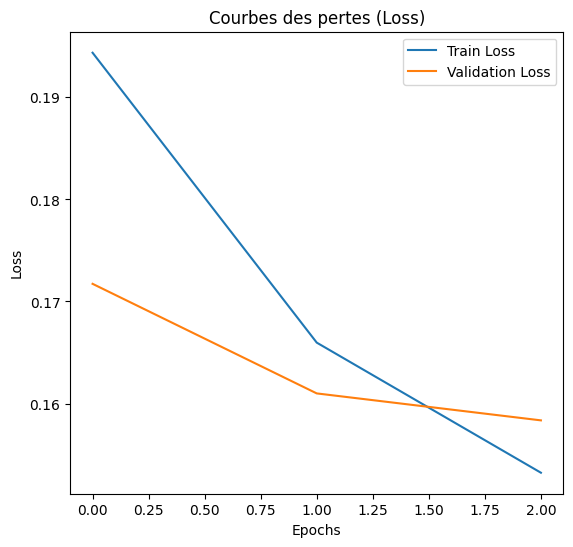

In [ ]:
# Tracer les courbes de performance (pertes et précisions)
plt.figure(figsize=(14, 6))

# Courbe des pertes (loss)
plt.subplot(1, 2, 1)
plt.plot(mean_train_loss, label='Train Loss')
plt.plot(mean_val_loss, label='Validation Loss')
plt.title('Courbes des pertes (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

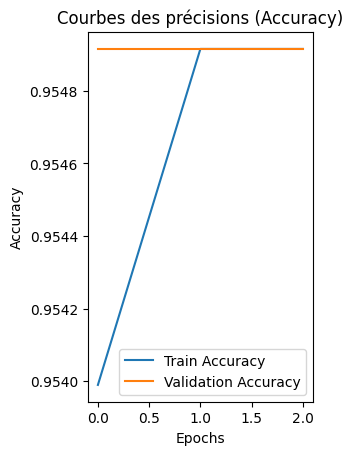

In [ ]:
# Courbe des précisions (accuracy)
plt.subplot(1, 2, 2)
plt.plot(mean_train_accuracy, label='Train Accuracy')
plt.plot(mean_val_accuracy, label='Validation Accuracy')
plt.title('Courbes des précisions (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


In [ ]:
plt.show()

In [ ]:
model.save('/content/drive/My Drive/modele-one-hot(dernière version 0.95 , loss non eleve).keras')